Các nhãn và số văn bản tương ứng trong dữ liệu
----------------------------------------------
doi-song: 120
du-lich: 54
giai-tri: 201
giao-duc: 105
khoa-hoc: 144
kinh-doanh: 262
phap-luat: 59
suc-khoe: 162
the-thao: 173
thoi-su: 59
-------------------------
Tổng số văn bản: 1339
mapping:
doi-song - 0
du-lich - 1
giai-tri - 2
giao-duc - 3
khoa-hoc - 4
kinh-doanh - 5
phap-luat - 6
suc-khoe - 7
the-thao - 8
thoi-su - 9
--------------------------
['data/news_vnexpress\\khoa-hoc\\00133.txt']
[4]
['Mời độc giả đặt câu hỏi tại đây\n']

Tổng số  văn bản: 1339
Số lượng stopwords: 2063
['a_lô', 'a_ha', 'ai', 'ai_ai', 'ai_nấy', 'ai_đó', 'alô', 'amen', 'anh', 'anh_ấy']

Số lượng từ trong từ điển: 12796
Kích thước dữ liệu sau khi xử lý: (1339, 12796)
Kích thước nhãn tương ứng: (1339,)
X


100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:18<00:00,  4.56s/it]


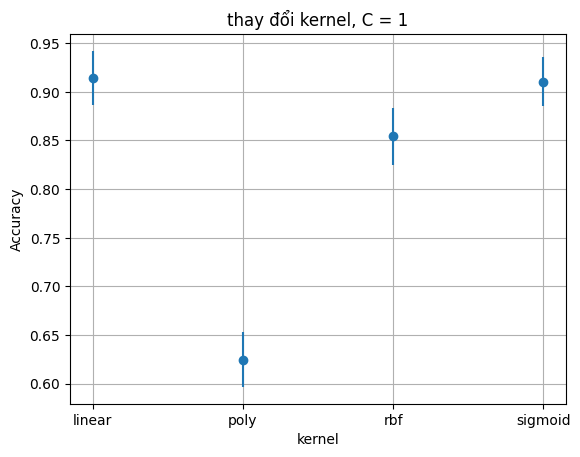

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:18<00:00,  3.77s/it]


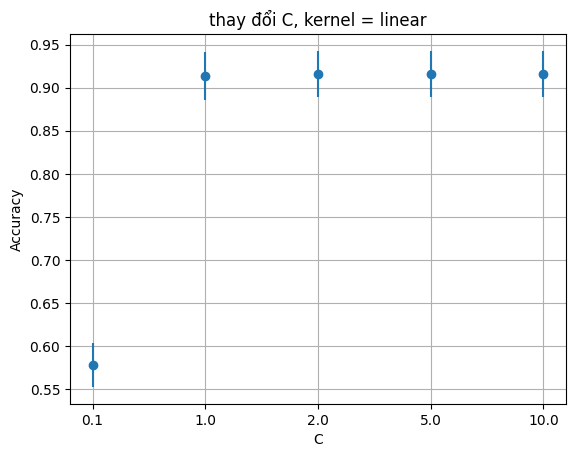

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:05<00:00,  2.86s/it]


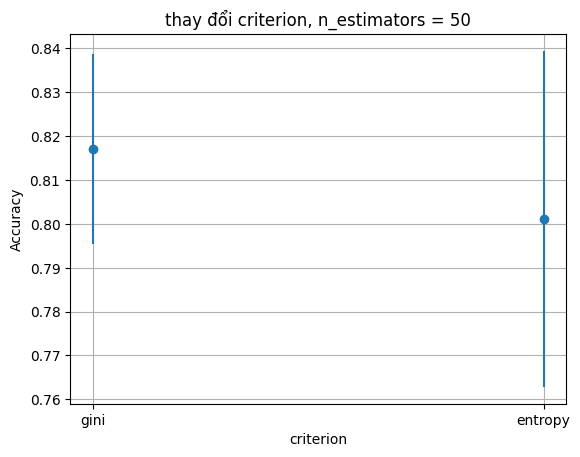

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:23<00:00,  5.87s/it]


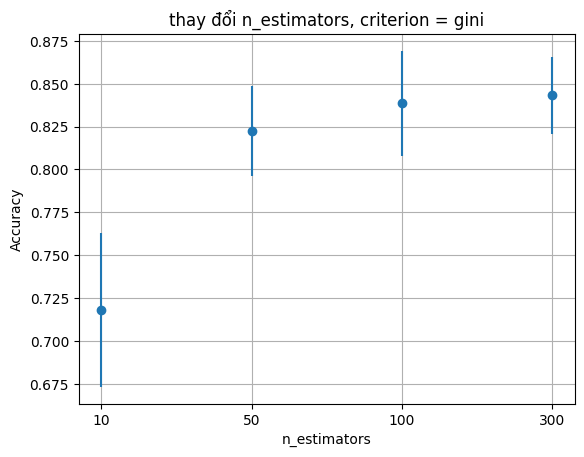

SVM: 0.9253731343283582
RF: 0.8059701492537313


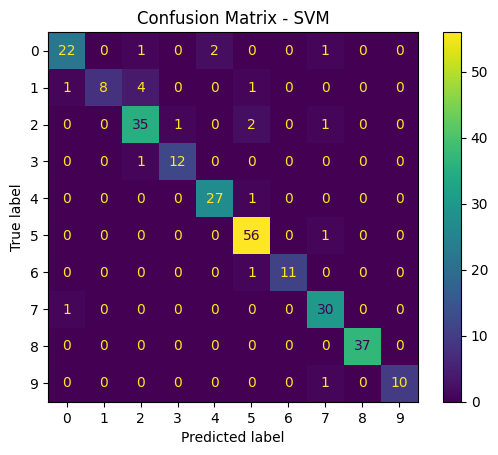

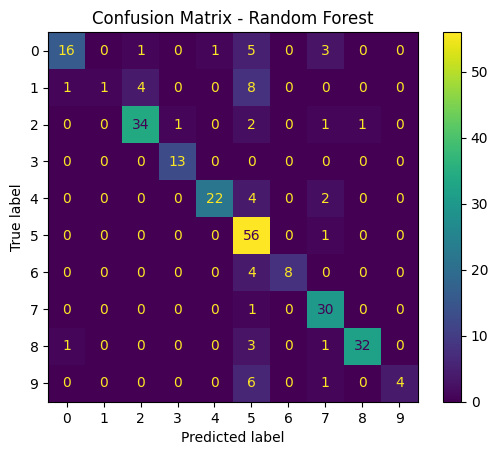

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve
from tqdm import tqdm

from sklearn.datasets import load_files
from pyvi import ViTokenizer

from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline

INPUT = 'data/news_vnexpress'
os.makedirs("images",exist_ok=True)  # thư mục lưu các hình ảnh kết quả trong quá trình huấn luyện và đánh giá

# statistics
print('Các nhãn và số văn bản tương ứng trong dữ liệu')
print('----------------------------------------------')
tongbv = 0
for label in os.listdir(INPUT):
    print(f'{label}: {len(os.listdir(os.path.join(INPUT, label)))}')  #duyet qua thu muc INPUT va in ten cac thu muc con va sl tep
    n += len(os.listdir(os.path.join(INPUT, label)))

print('-------------------------')
print(f"Tổng số văn bản: {tongbv}")

# load data
data_train = load_files(container_path=INPUT, encoding="utf-8")

print('mapping:')
for i in range(len(data_train.target_names)):
    print(f'{data_train.target_names[i]} - {i}')

print('--------------------------')
print(data_train.filenames[0:1])
# print(data_train.data[0:1])
print(data_train.target[0:1])
print(data_train.data[0:1])

print("\nTổng số  văn bản: {}" .format( len(data_train.filenames)))

# load dữ liệu các stopwords 
with open("data/vietnamese-stopwords.txt", encoding="utf-8") as f:
    stopwords = f.readlines()
stopwords = [x.strip().replace(" ", "_") for x in stopwords]  #strip() sẽ loại bỏ khoảng trắng 2 phía và replace để thay thế khoảng trắng bằng dấu _
print(f"Số lượng stopwords: {len(stopwords)}")
print(stopwords[:10])

# Chuyển hoá dữ liệu text về dạng vector TF 
#     - loại bỏ từ dừng
#     - sinh từ điển
module_count_vector = CountVectorizer(stop_words=stopwords)  #chỉnh định từ cần loại bỏ là cac stopword từ file vua doc
model_rf_preprocess = Pipeline([('vect', module_count_vector),
                    ('tf', TfidfTransformer()),
                    ])
# Hàm thực hiện chuyển đổi dữ liệu text thành dữ liệu số dạng ma trận 
# Input: Dữ liệu 2 chiều dạng numpy.array, mảng nhãn id dạng numpy.array 
data_preprocessed = model_rf_preprocess.fit_transform(data_train.data, data_train.target)

print(f"\nSố lượng từ trong từ điển: {len(module_count_vector.vocabulary_)}")
print(f"Kích thước dữ liệu sau khi xử lý: {data_preprocessed.shape}")
print(f"Kích thước nhãn tương ứng: {data_train.target.shape}")

#chia 
p = 0.2
pivot = int(data_preprocessed.shape[0] * (1-0.2))
X_train, X_test = data_preprocessed[0:pivot], data_preprocessed[pivot:]
print('X')
Y_train, Y_test = data_train.target[0:pivot], data_train.target[pivot:]

def cross_validation(estimator):
    _, train_scores, test_scores = learning_curve(estimator, X_train, Y_train, cv=10, n_jobs=-1, train_sizes=[1.0, ], scoring="accuracy")
    test_scores = test_scores[0]
    mean, std = test_scores.mean(), test_scores.std()
    return mean, std

def plot(title, xlabel, X, Y, error, ylabel = "Accuracy"):
    plt.xlabel(xlabel)
    plt.title(title)
    plt.grid()
    plt.ylabel(ylabel)
    
    plt.errorbar(X, Y, error, linestyle='None', marker='o')

# Đánh giá hiệu quả của các kernel trong SVM
title = "thay đổi kernel, C = 1"
xlabel = "kernel"
X = []
Y = []
error = []

for kernel in tqdm(['linear', 'poly', 'rbf', 'sigmoid']):
    # Với mỗi kernel được chọn, 
    # thực hiện xây dựng mô hình, huấn luyện và đánh giá theo cross-validation
    text_clf = svm.SVC(kernel=kernel, C=1.0)
    mean, std = cross_validation(text_clf)
    X.append(kernel)
    Y.append(mean)
    error.append(std)

# lưu kết quả ra file ảnh 
plot(title, xlabel, X, Y, error)
plt.savefig('images/svm_change_kernel.png', bbox_inches='tight')
plt.show()

title = "thay đổi C, kernel = linear"
xlabel = "C"
X = []
Y = []
error = []

for C in tqdm([.1, 1.0, 2.0, 5.0, 10.0]):
    # Với từng giá trị C nhận được, 
    # thực hiện xây dựng mô hình, huấn luyện và đánh giá theo cross-validation
    text_clf = svm.SVC(kernel='linear', C=C)
    mean, std = cross_validation(text_clf)
    X.append(str(C))
    Y.append(mean)
    error.append(std)

# lưu kết quả ra file ảnh
plot(title, xlabel, X, Y, error)
plt.savefig('images/svm_change_C.png', bbox_inches='tight')
plt.show()

title = "thay đổi criterion, n_estimators = 50"
xlabel = "criterion"
X = []
Y = []
error = []

for criterion in tqdm(["gini", "entropy"]):
    # Với mỗi criterion nhận được,
    # thực hiện xây dựng mô hình, huấn luyện và đánh giá theo cross-validation
    text_clf = RandomForestClassifier(criterion=criterion, n_estimators=50)
    mean, std = cross_validation(text_clf)
    X.append(str(criterion))
    Y.append(mean)
    error.append(std)

# lưu kết quả ra file ảnh
plot(title, xlabel, X, Y, error)
plt.savefig('images/RF_change_criterion.png', bbox_inches='tight')
plt.show()

title = "thay đổi n_estimators, criterion = gini"
xlabel = "n_estimators"
X = []
Y = []
error = []

for n_estimators in tqdm([10, 50, 100, 300]):
    # Với từng giá trị n_estimators nhận được,
    # thực hiện xây dựng mô hình, huấn luyện và đánh giá theo cross-validation
    text_clf = RandomForestClassifier(criterion='gini', n_estimators=n_estimators)
    mean, std = cross_validation(text_clf)
    X.append(str(n_estimators))
    Y.append(mean)
    error.append(std)

# lưu kết quả ra file ảnh
plot(title, xlabel, X, Y, error)
plt.savefig('images/RF_change_N.png', bbox_inches='tight')
plt.show()

svm_ = svm.SVC(kernel='linear', C=1.0)
rf = RandomForestClassifier(criterion='gini', n_estimators=100)

# Huấn luyện các mô hình trên tập dữ liệu train đầy đủ
svm_.fit(X_train, Y_train)
rf.fit(X_train, Y_train)

# Kết quả dự đoán trên tập test
print(f'SVM: {accuracy_score(Y_test, svm_.predict(X_test))}')
print(f'RF: {accuracy_score(Y_test, rf.predict(X_test))}')

# Dự đoán nhãn từ mô hình
y_pred_svm = svm_.predict(X_test)
y_pred_rf = rf.predict(X_test)

# Tạo ma trận nhầm lẫn
cm_svm = confusion_matrix(Y_test, y_pred_svm)
cm_rf = confusion_matrix(Y_test, y_pred_rf)

# Hiển thị ma trận nhầm lẫn
disp_svm = ConfusionMatrixDisplay(confusion_matrix=cm_svm)
disp_svm.plot()
plt.title("Confusion Matrix - SVM")
plt.show()

disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp_rf.plot()
plt.title("Confusion Matrix - Random Forest")
plt.show()

##thanh dài -0- là đổ lệch chuẩn, càng nhỏ thì càng ổn định
# Cross Validation đánh giá hiệu suất
#Kernel: Là một hàm được sử dụng để chuyển đổi dữ liệu đầu vào sang một không gian chiều cao hơn (có thể là vô hạn chiều) để dễ dàng phân loại. Các kernel phổ biến trong SVM bao gồm:

#Linear (tuyến tính): Dữ liệu được chuyển đổi một cách tuyến tính.
#Polynomial (đa thức): Dữ liệu được chuyển đổi bằng một đa thức.
#RBF (Radial Basis Function): Dữ liệu được chuyển đổi bằng một hàm RBF.
#Sigmoid (sigmoid): Dữ liệu được chuyển đổi bằng một hàm sigmoid.
